<a href="https://colab.research.google.com/github/imnawar/CS681_Assinments/blob/main/CS681_Assinment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS681 - Assginment 1





---
**Comparing GAN and VAE for Data Generation**
---

Manal Nawar Allahyani - 2400498




## Download and preprocess the dataset


We will use **Fashion-MNIST** dataset, which is available directly through PyTorch and TensorFlow. It's one of most stuible datasets for computer vision task.

We’ll normalize the images to the range [−1, 1], which is standard for GANs and VAEs, and set them up in a DataLoader for training.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Hyperparameters
batch_size = 128

# Transform: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

# DataLoader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Quick check
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)   # [batch_size, 1, 28, 28]
print("Label shape:", labels.shape)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.39MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.0MB/s]

Batch shape: torch.Size([128, 1, 28, 28])
Label shape: torch.Size([128])


Let’s visualize a batch of Fashion-MNIST images so we’re sure the preprocessing worked correctly.

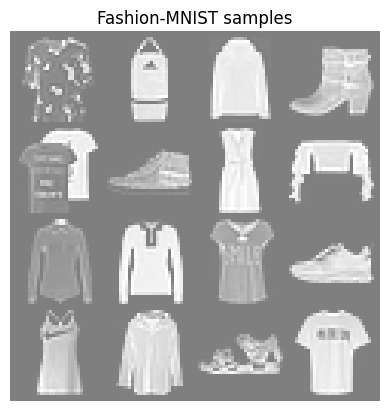

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and show images
def imshow(img, title=None):
    img = img / 2 + 0.5   # unnormalize from [-1, 1] back to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Get one batch
images, labels = next(iter(train_loader))

# Make a grid of the first 16 images
grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=True)

# Show grid
imshow(grid, title="Fashion-MNIST samples")


Now the data is normalized and ready for training. Next step is moving to VAE and GAN.

#VAE

## 1. Define the VAE architecture

We’ll use:

* Encoder → maps 28×28 images → latent mean & log-variance

* Reparameterization trick → sample latent z

* Decoder → maps latent z back to an image

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Latent space dimension
latent_dim = 20

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # output in [0,1]

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


## 2. Loss function (reconstruction + KL divergence)

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    # Rescale x from [-1, 1] → [0, 1]
    x = (x + 1) / 2

    BCE = F.binary_cross_entropy(
        recon_x, x.view(-1, 28*28), reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


## 3. Training loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 1, Average loss: 275.3554


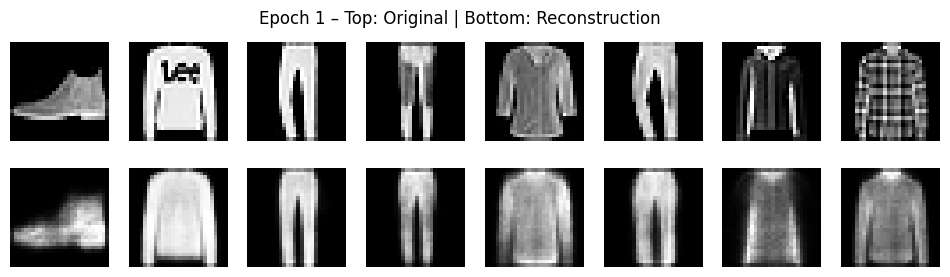

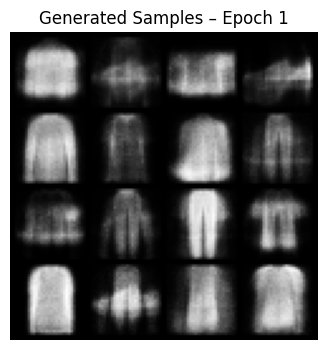

Epoch 2, Average loss: 253.0996


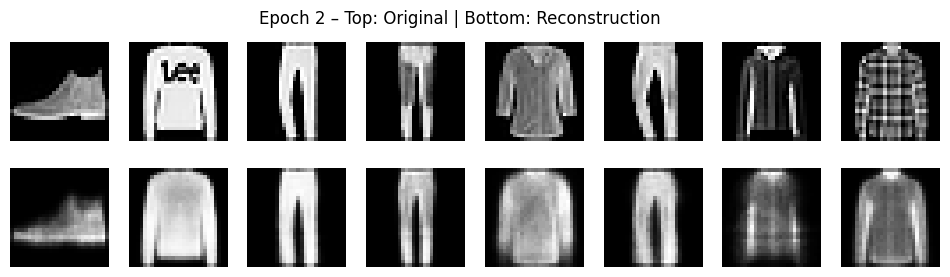

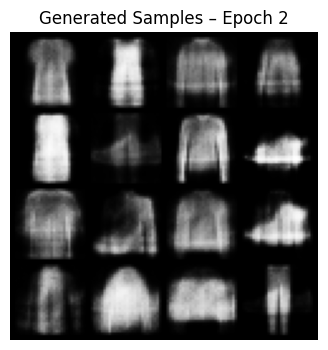

Epoch 3, Average loss: 249.0823


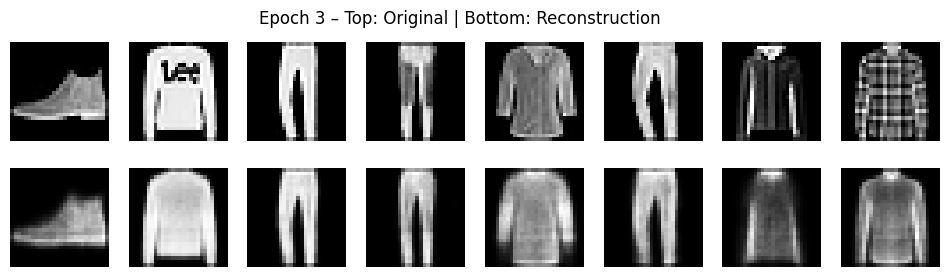

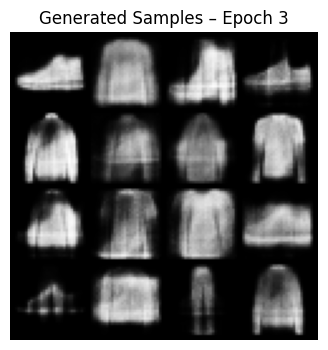

Epoch 4, Average loss: 247.0843


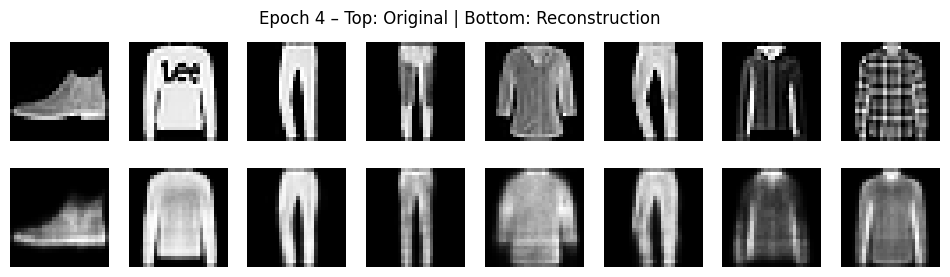

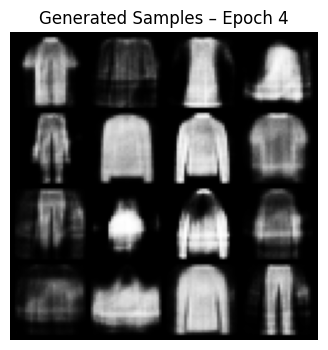

Epoch 5, Average loss: 245.8031


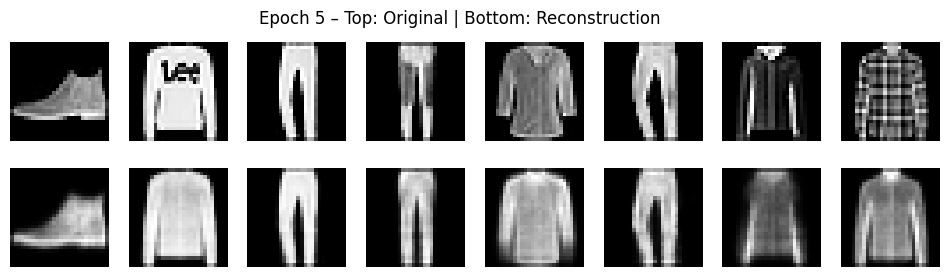

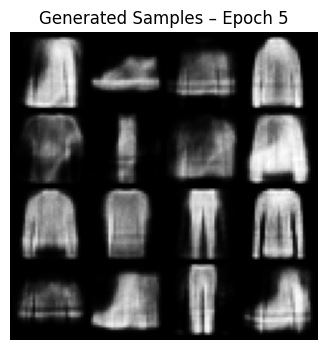

Epoch 6, Average loss: 244.9294


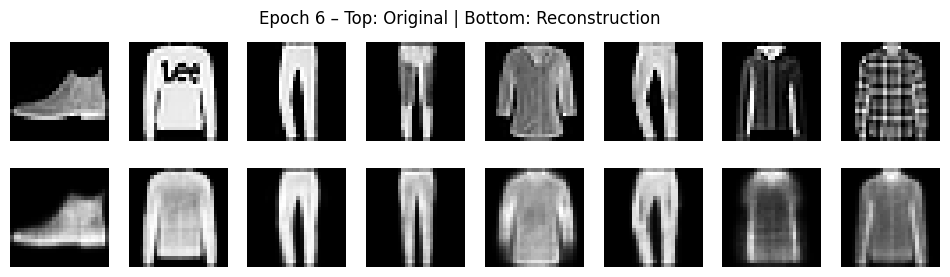

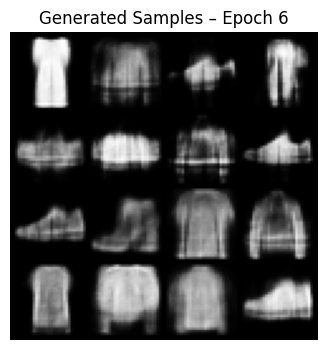

Epoch 7, Average loss: 244.2236


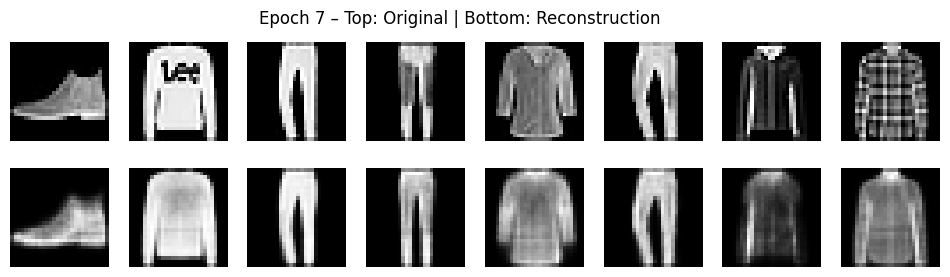

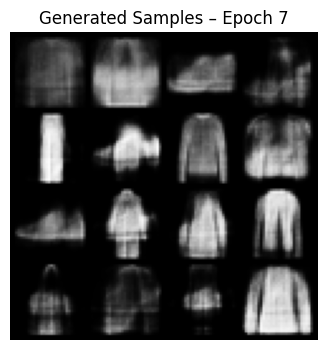

Epoch 8, Average loss: 243.6664


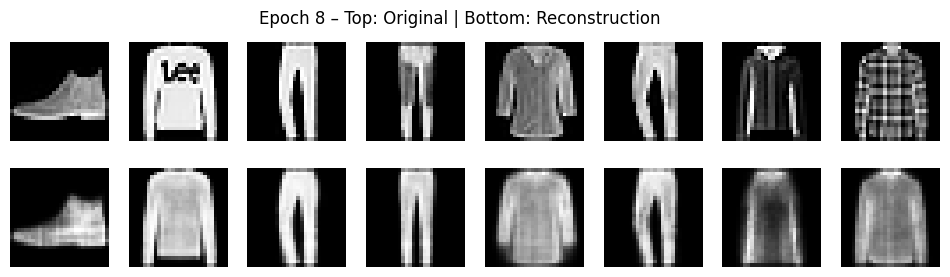

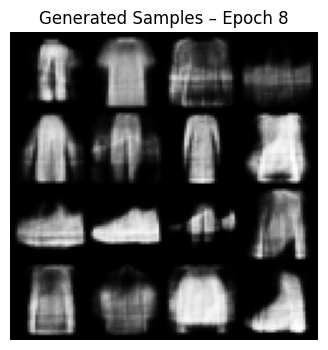

Epoch 9, Average loss: 243.2310


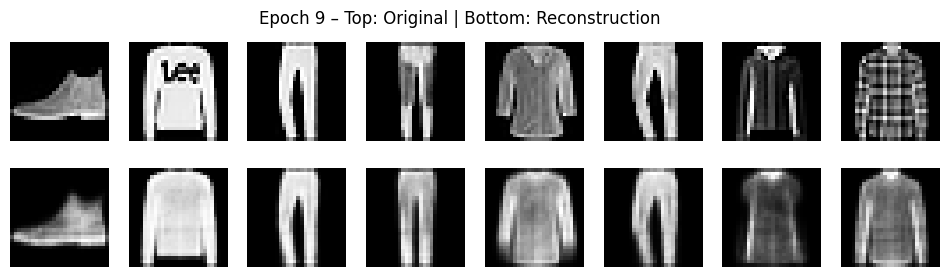

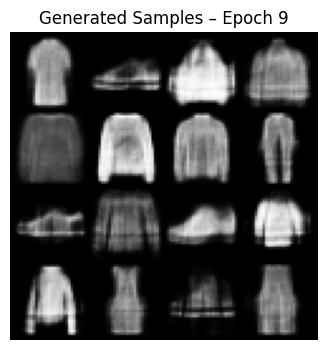

Epoch 10, Average loss: 242.8016


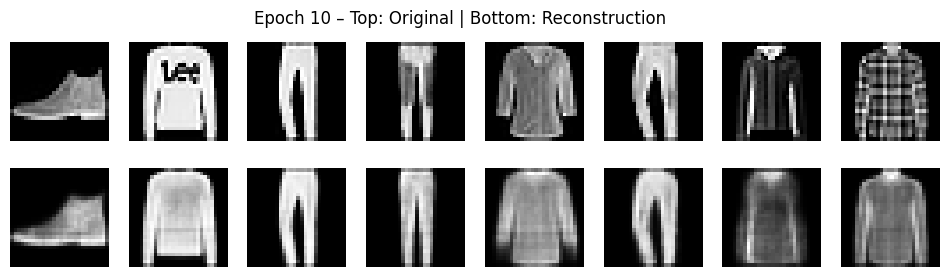

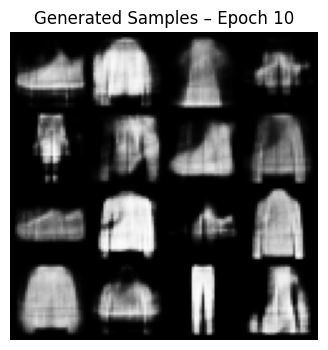

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def show_images(orig, recon, epoch):
    """Show original vs reconstructed images"""
    orig = orig[:8].cpu()
    recon = recon[:8].cpu()

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        # Original
        axes[0, i].imshow(orig[i].squeeze(), cmap="gray")
        axes[0, i].axis("off")
        # Reconstruction
        axes[1, i].imshow(recon[i].squeeze(), cmap="gray")
        axes[1, i].axis("off")

    plt.suptitle(f"Epoch {epoch} – Top: Original | Bottom: Reconstruction")
    plt.show()

def show_generated(model, epoch, latent_dim=20):
    """Sample from latent space and show generated images"""
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z).cpu().view(-1, 1, 28, 28)
        grid = torchvision.utils.make_grid(samples, nrow=4, normalize=True)
        plt.figure(figsize=(4,4))
        plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"Generated Samples – Epoch {epoch}")
        plt.show()

# Training loop
epochs = 10
for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Average loss: {avg_loss:.4f}")

    # --- Visualization after each epoch ---
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon_batch, _, _ = model(data)
        show_images(data, recon_batch.view(-1, 1, 28, 28), epoch)
        show_generated(model, epoch, latent_dim)


#GAN

## 1. Define Generator & Discriminator

In [ ]:
import torch.nn as nn

# Latent space dimension (input noise)
z_dim = 100

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_dim),
            nn.Tanh()  # output in [-1,1]
        )

    def forward(self, z):
        return self.gen(z)


class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.disc(img)

## 2. Initialize models, loss, optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 2e-4

opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

## 3. Training loop

Epoch [1/10] Loss D: 0.2200, Loss G: 3.6446


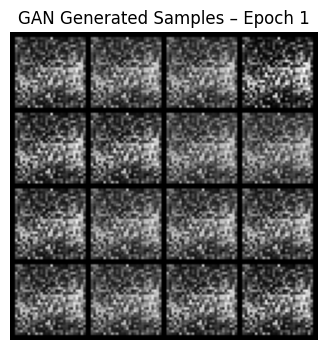

Epoch [2/10] Loss D: 0.2301, Loss G: 2.5964


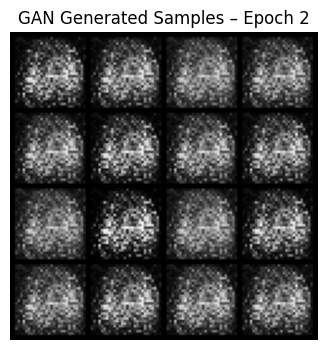

Epoch [3/10] Loss D: 0.1473, Loss G: 3.0892


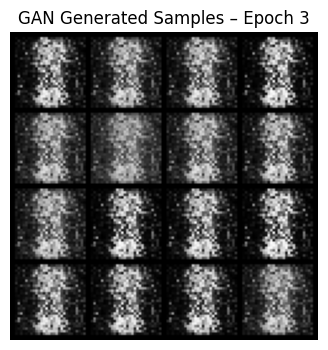

Epoch [4/10] Loss D: 0.1451, Loss G: 4.4004


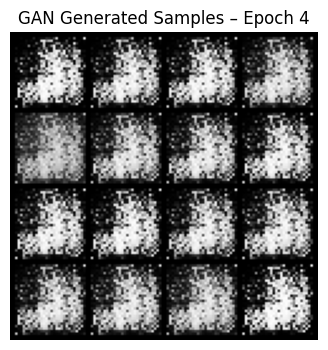

Epoch [5/10] Loss D: 0.1933, Loss G: 5.2045


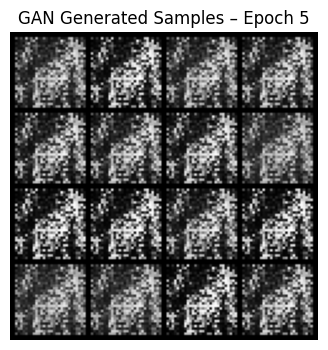

Epoch [6/10] Loss D: 0.3458, Loss G: 2.4867


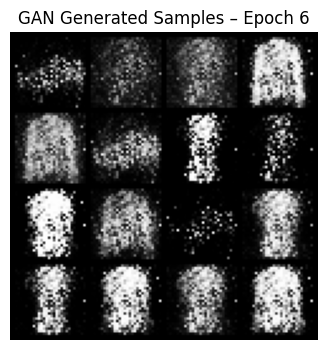

Epoch [7/10] Loss D: 0.3441, Loss G: 4.0172


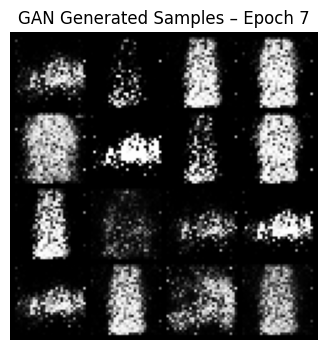

Epoch [8/10] Loss D: 0.4614, Loss G: 2.0813


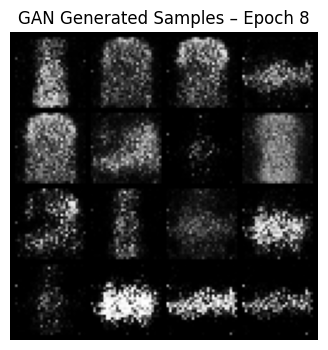

Epoch [9/10] Loss D: 0.5152, Loss G: 1.3260


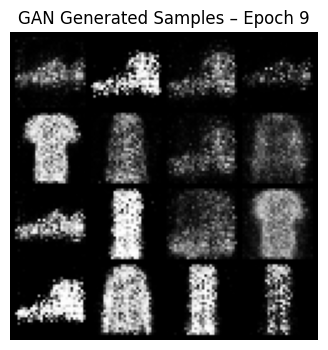

Epoch [10/10] Loss D: 0.5289, Loss G: 1.1764


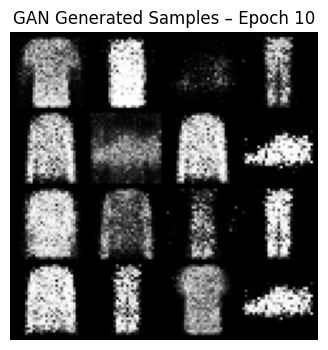

In [ ]:
import torchvision

epochs = 10

for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.view(-1, 28*28).to(device)
        batch_size = real.size(0)

        ### Train Discriminator ###
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)

        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        lossD = (lossD_real + lossD_fake) / 2
        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### Train Generator ###
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))

        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

    # Generate samples after each epoch
    with torch.no_grad():
        noise = torch.randn(16, z_dim).to(device)
        fake = gen(noise).view(-1, 1, 28, 28).cpu()
        grid = torchvision.utils.make_grid(fake, nrow=4, normalize=True)
        plt.figure(figsize=(4,4))
        plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"GAN Generated Samples – Epoch {epoch+1}")
        plt.show()

#Comparison

##1. Visual Comparison: VAE vs GAN

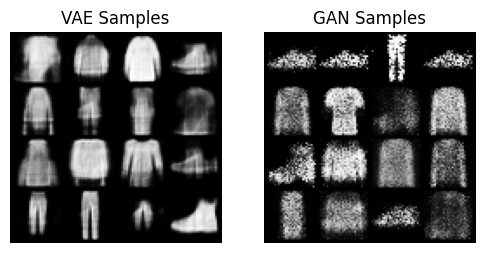

In [ ]:
# --- VAE Generated Samples ---
model.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    vae_samples = model.decode(z).cpu().view(-1, 1, 28, 28)
    vae_grid = torchvision.utils.make_grid(vae_samples, nrow=4, normalize=True)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(vae_grid.permute(1,2,0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("VAE Samples")

# --- GAN Generated Samples ---
gen.eval()
with torch.no_grad():
    noise = torch.randn(16, z_dim).to(device)
    gan_samples = gen(noise).cpu().view(-1, 1, 28, 28)
    gan_grid = torchvision.utils.make_grid(gan_samples, nrow=4, normalize=True)

plt.subplot(1,2,2)
plt.imshow(gan_grid.permute(1,2,0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("GAN Samples")
plt.show()

* The images of **VAE** are recognizable as Fashion-MNIST clothing items (shirts, trousers, dresses, etc.). However, they are blurry and smooth, with less sharpness in the edges and missing finer details like collars or textures.

* Some of **GAN** samples show sharper outlines and higher contrast than the VAE results. But the quality is inconsistent — several outputs look noisy, fragmented, or unrealistic.

##2. Quantitative Metrics

## **Fréchet Inception Distance (FID)**


*   Measures distance between distributions of real vs generated images in feature space.
*   ***Lower = better.***

In [ ]:
!pip install pytorch-fid

In [ ]:
from pytorch_fid import fid_score

# Save some generated and real samples into folders
import os
from torchvision.utils import save_image

os.makedirs("vae_samples", exist_ok=True)
os.makedirs("gan_samples", exist_ok=True)
os.makedirs("real_samples", exist_ok=True)

# Generate VAE images
model.eval()
with torch.no_grad():
    for i in range(500):  # generate 500 samples
        z = torch.randn(1, latent_dim).to(device)
        sample = model.decode(z).cpu().view(1,1,28,28)
        save_image(sample, f"vae_samples/{i}.png", normalize=True)

# Generate GAN images
gen.eval()
with torch.no_grad():
    for i in range(500):
        z = torch.randn(1, z_dim).to(device)
        sample = gen(z).cpu().view(1,1,28,28)
        save_image(sample, f"gan_samples/{i}.png", normalize=True)

# Save real test images
for i, (img, _) in enumerate(test_loader):
    if i*len(img) >= 500: break
    for j in range(img.size(0)):
        idx = i*len(img)+j
        if idx >= 500: break
        save_image(img[j], f"real_samples/{idx}.png", normalize=True)

# Compute FID
fid_vae = fid_score.calculate_fid_given_paths(["real_samples", "vae_samples"], batch_size=50, device=device, dims=2048)
fid_gan = fid_score.calculate_fid_given_paths(["real_samples", "gan_samples"], batch_size=50, device=device, dims=2048)

print(f"FID (VAE): {fid_vae:.2f}")
print(f"FID (GAN): {fid_gan:.2f}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


100%|██████████| 91.2M/91.2M [00:01<00:00, 92.2MB/s]
100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


FID (VAE): 126.92
FID (GAN): 214.76


For these 500 samples, the VAE statistically outperformed the GAN in FID, showing better coverage of the Fashion-MNIST distribution, but qualitatively the images lack sharpness. The GAN generated some sharper images, but instability led to a much higher FID.

## **Inception Score (IS)**

*   Measures quality + diversity of generated images.
*   ***Higher = better.***


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.2 MB/s eta 0:00:00


In [ ]:
!pip install torch-fidelity

In [ ]:
!pip install torchmetrics[image]

In [ ]:
import os
from PIL import Image
from torchvision import transforms
import torch
from torchmetrics.image.inception import InceptionScore

# Folder containing generated images
folder = "gan_samples"

# Transform: convert to tensor, match IS expectations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception expects 299x299
    transforms.ToTensor()
])

# Load all images into a tensor
images = []
for file in os.listdir(folder):
    if file.endswith(".png"):
        img_path = os.path.join(folder, file)
        img = Image.open(img_path).convert("RGB")
        img = transform(img)
        images.append(img.unsqueeze(0).type(dtype=torch.uint8))  # add batch dim

images = torch.cat(images, dim=0)  # shape: [N, 3, 299, 299]

# Inception Score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception = InceptionScore().to(device)

images = images.to(device)
score = inception(images)

print(f"Inception Score for {folder}: {score}")


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Inception Score for gan_samples: (tensor(1.0049, device='cuda:0'), tensor(0.0018, device='cuda:0'))


In [ ]:
# Folder containing generated images
folder = "vae_samples"

# Transform: convert to tensor, match IS expectations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception expects 299x299
    transforms.ToTensor()
])

# Load all images into a tensor
images = []
for file in os.listdir(folder):
    if file.endswith(".png"):
        img_path = os.path.join(folder, file)
        img = Image.open(img_path).convert("RGB")
        img = transform(img)
        images.append(img.unsqueeze(0).type(dtype=torch.uint8))  # add batch dim

images = torch.cat(images, dim=0)  # shape: [N, 3, 299, 299]

# Inception Score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception = InceptionScore().to(device)

images = images.to(device)
score = inception(images)

print(f"Inception Score for {folder}: {score}")


Inception Score for vae_samples: (tensor(1.0019, device='cuda:0'), tensor(0.0019, device='cuda:0'))


Inception Scores (IS):

**GAN Samples IS** = 1.0049 ± 0.0018

**VAE Samples IS** = 1.0019 ± 0.0019

While the VAE achieved better FID, the GAN achieved a slightly higher Inception Score. This demonstrates the trade-off:

* VAE → closer to the data distribution overall (better FID) but blurry and less diverse (lower IS).

* GAN → produces some sharper images (slightly better IS), but with instability and noise that worsens its FID.

# Key Findings

## Strengths and weaknesses
In this assignment, two fundamental models in generative computer vision —GAN and VAE— are utilized. The key findings are summarized below.

1.   Training a **VAE** is generally more stable, faster, and computationally efficient; however, its outputs often appear blurry and may lose fine details in the generated or reconstructed images.
2.   The generated images using **GAN** have some details such as a print on T-shirt. While it's dificlut to find a balance between the Generator and Discrimnitor in the training loop. That makes training a GAN model not stable and slower than the VAE.

## Limitations and challenges of this assinment:


1.   Limited resources.
2.   Lack of Large divrse datasets.
